This is the Code for the FKAN Project in the Biostatistics Course 2024/2025

This Jupyter Notebook is to practice/test some thing on the general KAN algorithm before testing the federal KAN

Here KALnet is tested


In [1]:


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import time
from functools import lru_cache
from torchvision import models
from torch.optim import lr_scheduler


Importing Data Set from Kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\rateb\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [3]:
import os
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Resize the image
                
                # Add image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    
    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# Load the data
train_data = get_training_data('/Users/rateb/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train')
test_data = get_training_data('/Users/rateb/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test')
val_data = get_training_data('/Users/rateb/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')


In [4]:
# Assume that 'train_data' contains data with labels already assigned
l = []
for i in train_data:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

# Create a DataFrame with pandas
df = pd.DataFrame(l, columns=['Class'])

# Calculate the frequency of each class
class_counts = df['Class'].value_counts()

# Print the frequency of the classes
print("Frequency of classes in the training set:")
print(class_counts)

Frequency of classes in the training set:
Class
Pneumonia    3875
Normal       1341
Name: count, dtype: int64


Here Images are normalized

In [5]:
# Function to normalize images
def normalize_images(data):
    images = []
    labels = []
    
    for img, label in data:
        # Normalization: each pixel is divided by 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)
    
    # Convert images and labels into separate arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Normalize the images in the training dataset
train_images_pre, train_labels_pre = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)

# Check the shape and an example of the normalized data
print(f"Shape of normalized train images: {train_images_pre.shape}")

Shape of normalized train images: (5216, 150, 150)


In [6]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training set (80%) and validation set (20%)
train_images, val_images, train_labels, val_labels = train_test_split(train_images_pre, train_labels_pre, test_size=0.2, random_state=42)

# Check the shape and an example of the split data
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of validation images: {val_images.shape}")

Shape of training images: (4172, 150, 150)
Shape of validation images: (1044, 150, 150)


In [7]:
# Assume that 'train_labels' contains the labels (0 and 1)
prova_l = []
for label in train_labels:
    if label == 0:
        prova_l.append("Pneumonia")
    else:
        prova_l.append("Normal")

# Create a DataFrame with pandas
df = pd.DataFrame(prova_l, columns=['Class'])

# Calculate the frequency of each class
class_counts = df['Class'].value_counts()

# Print the frequency of the classes
print("Frequency of classes in the training set:")
print(class_counts)

Frequency of classes in the training set:
Class
Pneumonia    3122
Normal       1050
Name: count, dtype: int64


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

# Identify images of the "Normal" and "Pneumonia" classes
normal_images = train_images[train_labels == 1]  # Only "Normal" images
normal_labels = train_labels[train_labels == 1]  # Corresponding labels
pneumonia_images = train_images[train_labels == 0]  # Only "Pneumonia" images
pneumonia_labels = train_labels[train_labels == 0]  # Corresponding labels

# Add a channel dimension (1 for grayscale images)
normal_images = np.expand_dims(normal_images, axis=-1)
pneumonia_images = np.expand_dims(pneumonia_images, axis=-1)

# Determine the target number of images to balance the dataset
target_normal_images_count = pneumonia_images.shape[0] 
current_normal_images_count = normal_images.shape[0]
images_to_generate = target_normal_images_count - current_normal_images_count

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images to balance the dataset
augmented_normal_images = []
if images_to_generate > 0:
    augmented_data_gen = datagen.flow(normal_images, normal_labels, batch_size=32, shuffle=False)
    for _ in range(images_to_generate // 32 + 1):
        batch_images, _ = next(augmented_data_gen)
        augmented_normal_images.append(batch_images)

    # Concatenate all generated images
    augmented_normal_images = np.vstack(augmented_normal_images)[:images_to_generate]
else:
    augmented_normal_images = np.empty((0, *normal_images.shape[1:]))

# Concatenate original and augmented images for the "Normal" class
balanced_normal_images = np.concatenate([normal_images, augmented_normal_images])
balanced_normal_labels = np.full(balanced_normal_images.shape[0], 1)

# Create the final balanced dataset
augmented_train_images = np.concatenate([pneumonia_images, balanced_normal_images])
augmented_train_labels = np.concatenate([pneumonia_labels, balanced_normal_labels])

# Shuffle the dataset randomly
augmented_train_images, augmented_train_labels = shuffle(augmented_train_images, augmented_train_labels)

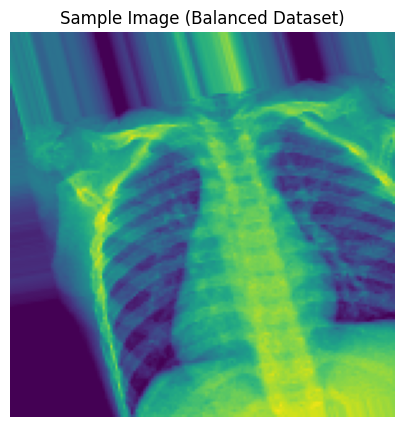

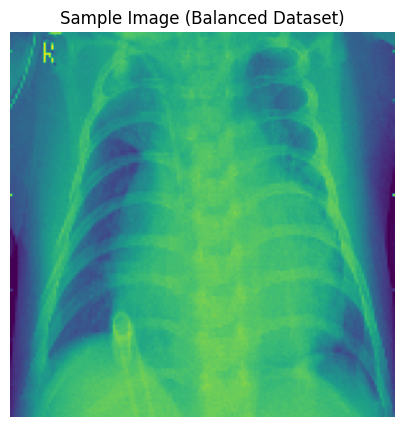

In [9]:
augmented_train_images_normalized = augmented_train_images / 255.0

# Visualizzare alcune immagini per conferma
plt.figure(figsize=(5, 5))
plt.imshow(augmented_train_images[0].reshape(150, 150))
plt.title('Sample Image (Balanced Dataset)')
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(augmented_train_images[-1].reshape(150, 150))
plt.title('Sample Image (Balanced Dataset)')
plt.axis('off')
plt.show()

In [10]:
#val_images = np.expand_dims(val_images, axis=-1)  # Diventa (16, 150, 150, 1)

KAL_NET definition


In [11]:
class KAL_Net(nn.Module):
    def __init__(self, layers_hidden=[22500, 1024, 128], polynomial_order=3, base_activation=nn.SiLU):
        super(KAL_Net, self).__init__()
        self.layers_hidden = layers_hidden
        self.polynomial_order = polynomial_order
        self.base_activation = base_activation()
        
        self.base_weights = nn.ParameterList()
        self.poly_weights = nn.ParameterList()
        self.layer_norms = nn.ModuleList()

        # Define layers based on the provided hidden layers structure
        for in_features, out_features in zip(layers_hidden[:-1], layers_hidden[1:]):
            self.base_weights.append(nn.Parameter(torch.randn(out_features, in_features)))
            self.poly_weights.append(nn.Parameter(torch.randn(out_features, in_features * (polynomial_order + 1))))
            self.layer_norms.append(nn.LayerNorm(out_features))

        # Output layer for binary classification
        self.output_layer = nn.Linear(layers_hidden[-1], 2)  # Change to 2 for multi-class (0 and 1 labels)
        
        for weight in self.base_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')
        for weight in self.poly_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')

    @staticmethod
    def compute_legendre_polynomials(x, order):
        P0 = torch.ones_like(x)
        if order == 0:
            return P0.unsqueeze(-1)
        P1 = x
        legendre_polys = [P0, P1]
        
        for n in range(1, order):
            Pn = ((2.0 * n + 1.0) * x * legendre_polys[-1] - n * legendre_polys[-2]) / (n + 1.0)
            legendre_polys.append(Pn)
        
        return torch.stack(legendre_polys, dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten the input correctly to match the input size of 22500
        
        for base_weight, poly_weight, layer_norm in zip(self.base_weights, self.poly_weights, self.layer_norms):
            base_output = F.linear(self.base_activation(x), base_weight)
            
            x_normalized = 2 * (x - x.min()) / (x.max() - x.min()) - 1
            legendre_basis = self.compute_legendre_polynomials(x_normalized, self.polynomial_order)
            legendre_basis = legendre_basis.view(batch_size, -1)

            poly_output = F.linear(legendre_basis, poly_weight)
            x = self.base_activation(layer_norm(base_output + poly_output))

        x = self.output_layer(x)
        return torch.softmax(x, dim=1)  # Use softmax for multi-class classification

# Example instantiation
model = KAL_Net()

# Ensure the model is on the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Training the Model


In [12]:
# Assume that your data is already in numpy format and normalized between 0 and 1
# Load the data as tensors
train_images_tensor = torch.tensor(augmented_train_images_normalized, dtype=torch.float32)
val_images_tensor = torch.tensor(val_images, dtype=torch.float32)

# Add a dimension for the channel (1 channel for grayscale images)
train_images_tensor = train_images_tensor.squeeze(-1)  # Shape: (7750, 1, 150, 150)
val_images_tensor = val_images_tensor.squeeze(-1)      # Shape: (16, 1, 150, 150)

# Explicitly add the dimension for the channel
train_images_tensor = train_images_tensor.unsqueeze(1)  # Shape: (7750, 1, 150, 150)
val_images_tensor = val_images_tensor.unsqueeze(1)      # Shape: (16, 1, 150, 150)

# Create the targets (labels) as tensors (assuming the targets are already prepared)
train_labels_tensor = torch.tensor(augmented_train_labels, dtype=torch.long)  # Shape: (7750,)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)      # Shape: (16,)

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definizione della funzione di perdita e ottimizzatore
criterion = nn.CrossEntropyLoss()  # Per classificazione multi-classe o binaria
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler for learning rate reduction
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function with Early Stopping
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        print(f'Train Loss: {train_loss:.4f} Train Acc: {train_accuracy:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, val_preds = torch.max(outputs, 1)
                val_correct += torch.sum(val_preds == labels).item()
                val_total += labels.size(0)

        val_loss /= len(valid_loader.dataset)
        val_accuracy = val_correct / val_total
        print(f'Validation Loss: {val_loss:.4f} Validation Acc: {val_accuracy:.4f}')

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print('Model saved!')
        else:
            epochs_no_improve += 1
            print(f'Early Stopping Counter: {epochs_no_improve}/{patience}')

        # Early stopping
        if epochs_no_improve >= patience:
            print('Early stopping triggered.')
            break

        # Update the learning rate
        scheduler.step()

# Call the training function
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5)

Epoch 1/25
Train Loss: 0.5272 Train Acc: 0.7647
Validation Loss: 0.4027 Validation Acc: 0.9100
Model saved!
Epoch 2/25
Train Loss: 0.4054 Train Acc: 0.9041
Validation Loss: 0.3834 Validation Acc: 0.9291
Model saved!
Epoch 3/25
Train Loss: 0.3778 Train Acc: 0.9339
Validation Loss: 0.4197 Validation Acc: 0.8889
Early Stopping Counter: 1/5
Epoch 4/25
Train Loss: 0.3734 Train Acc: 0.9374
Validation Loss: 0.3867 Validation Acc: 0.9234
Early Stopping Counter: 2/5
Epoch 5/25
Train Loss: 0.3659 Train Acc: 0.9454
Validation Loss: 0.4815 Validation Acc: 0.8266
Early Stopping Counter: 3/5
Epoch 6/25
Train Loss: 0.3662 Train Acc: 0.9444
Validation Loss: 0.3895 Validation Acc: 0.9167
Early Stopping Counter: 4/5
Epoch 7/25
Train Loss: 0.3625 Train Acc: 0.9500
Validation Loss: 0.3598 Validation Acc: 0.9502
Model saved!
Epoch 8/25
Train Loss: 0.3434 Train Acc: 0.9693
Validation Loss: 0.3781 Validation Acc: 0.9301
Early Stopping Counter: 1/5
Epoch 9/25
Train Loss: 0.3413 Train Acc: 0.9710
Validation Lo

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()  # For multi-class or binary classification

# Load the saved model
model = model.to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Evaluation mode

# Test data
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)  # Use your test data
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)  # Use your test labels

# Add the channel dimension for the model (1 channel for grayscale images)
test_images_tensor = test_images_tensor.unsqueeze(1)  # Shape: (n_test, 1, 150, 150)

# Create the dataset and DataLoader for testing
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate loss and accuracy on the test data
test_loss = 0.0
correct_preds = 0
total_preds = 0
all_preds = []
all_labels = []

with torch.no_grad():  # Do not calculate gradients during testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        # Calculate predictions
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

        # Store predictions and labels for F1 score calculation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the average loss and final accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct_preds / total_preds

# Compute F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

C:\Users\rateb\AppData\Local\Temp\ipykernel_19012\3665543305.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Loss: 0.5316
Test Accuracy: 0.7724
F1 Score: 0.7477
